# IMDB Regularization and Dropout Example
### This Example was adapted from Deep Learning with Python Chapter 3 and 4 Chollet, F. (2017). Deep Learning with Python (1st ed.). Greenwich, CT, USA: Manning Publications Co.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## We will improve our previous IMDB neural net by adding regularization, dropout, batch normalization, and early stopping.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

# When we import the data we only select the 10,000 most common words in the reviews.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Previous Baseline Model

In [ ]:
# Remember, we cannot add a single vector to a neural network. The data needs to be 
# converted to a tensor. This function will create a tensor that is N by 10000.
# N is the number of samples and 10000 is the number of unique words. The sparse tensor
# will have all zeroes except for ones where that word is in the review
def vectorize_sequences(sequences, dimension=10000):
    word_matrix = tf.sparse.SparseTensor(
        # The non-zero locations in each row correspond to the word indices that are found in the document
        indices=[[row_idx, word_idx] for row_idx, word_indices in enumerate(sequences) for word_idx in set(word_indices)],
        # Use "1" as the value of each non-zero index (indicating the word is used in the document)
        values=[1 for row_idx, word_indices in enumerate(sequences) for word_idx in set(word_indices)],
        # The overall tensor shape
        dense_shape=[len(sequences), dimension]
    )
    # Optimize by ordering the non-zero indices in ascending row-major order
    word_matrix = tf.sparse.reorder(word_matrix)
    return word_matrix

In [ ]:
# Split the training data into a 75/25 train/validation split
train_data, valid_data, train_labels, valid_labels = train_test_split(
    train_data, train_labels, test_size=0.25, random_state=42)

In [ ]:
# Apply the vectorize function to the train_data and test_data
x_train = vectorize_sequences(train_data)
x_valid = vectorize_sequences(valid_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# Convert the y targets to float32
y_train = np.asarray(train_labels).astype('float32')
y_valid = np.asarray(valid_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
# Import the keras libraries
from keras import models, layers, regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend

In [ ]:
# Build the model architecture.  Input shape must equal the number of vectore or (unique words).
# Add one hidden layer with 16 nodes.  Keep the activation function as 'relu'
# Since we have a binary classification, the output activation function will be 'sigmoid'
# We will keep with the 'adam' optomizer function, loss = 'binary_crossentropy', and metrics = 'accuracy'
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# Fit the model to the training data. 
history = model.fit(x_train,
                   y_train,
                   epochs = 20,
                   batch_size = 500,
                   validation_data = (x_valid, y_valid))

In [ ]:
hist = pd.DataFrame(history.history)
display(hist)

In [ ]:
# Let's plot the Loss vs Epochs and Accuracy vs Epochs
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

In [ ]:
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# It looks like the Validation Loss increases after about 4 Epochs and the validation accuracy decreases after about 
# 4 epochs.  Lets refit the data but only use 4 epochs and then apply the model on the test data
backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
model.fit(x_train,
          y_train,
          epochs = 4,
          batch_size = 500)
results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print(results)

## Let us try to improve on our above accuracy by using regularization, dropout, batch normalization, and early stopping

*Regularization* involves modifying the loss function by imposing additional constraints or penalties on the weights that the network learns. Two popular choices of regularizers are $\mathbf{L}_1$ and $\mathbf{L}_2$ penalties on the weights, which seek to penalize non-zero weights and large weights, respectively.

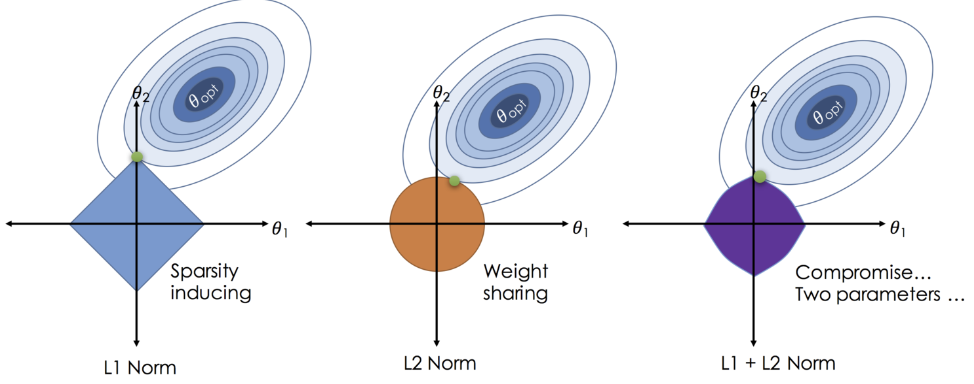

*Dropout* entails (randomly) removing a certain percentage of hidden nodes from the network during a mini-batch training step. This forces the remaining nodes to learn to adapt to the training data without help, i.e., learn more robust features of the data rather than relying on other nodes to do the "heavy lifting".

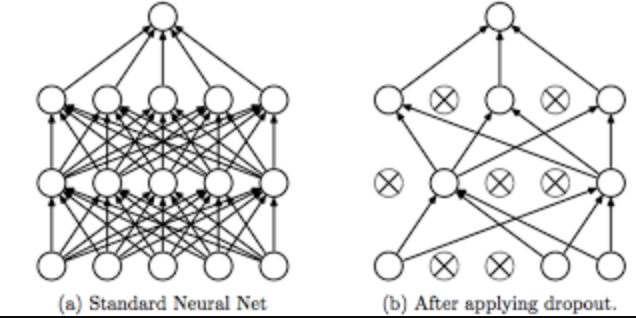

*Batch normalization* is the process of re-scaling the activations of intermediate nodes of a network so that we end up with more predictable gradient updates, which can speed up network convergence. Specifically, during mini-batch updates, the network computes the mean and variance of the incoming activations, standardizes them, and then scales by learnable mean and variance parameters.

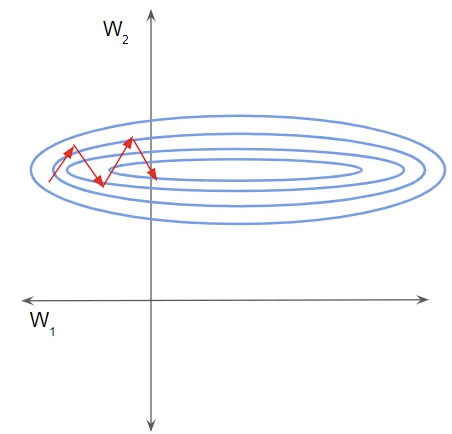 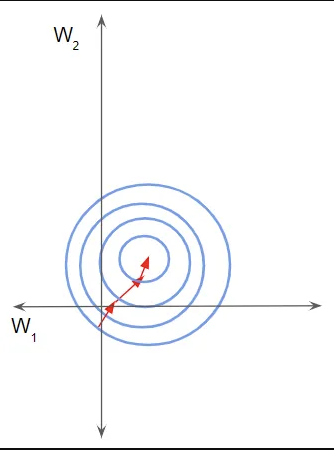

In [ ]:
# Add Dropouts, batch normalization, add more hidden layers with more hidden units
backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001), input_shape = (10000,)))
model.add(layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.Dense(16, kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(x_train,
                   y_train,
                   epochs = 20,
                   batch_size = 500,
                   validation_data = (x_valid, y_valid),
                   callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test)
print(model.metrics_names)
print(results)